# Warping an image using affine and perspective transformations

In this recipe, we will review two main ways to geometrically transform images: affine and perspective warps. The first one is used to remove simple geometrical transformations such as rotations, scales, translations, and their combinations, but it can't turn converging lines into parallel ones. Here, perspective transformation comes into play. It aims to eliminate perspective distortions when two parallel lines converge in perspective views. Let's find out how to use all these transformations in OpenCV.

Both affine and perspective transformations are essentially matrix multiplication operations, where positions of elements are remapped with some warp matrix. So, to apply a transformation we need to compute such a warp matrix. For affine transformation, this can be done with the `cv2.getAffineTransform` function. It takes two set of points as arguments: the first one contains three points before transformation, and the second one contains three corresponding points after warp. The order of points in the sets does matter, and it should be the same for both arrays. To create the transformation matrix in the case of perspective warp, `cv2.getPerspectiveTransform` can be applied.

Again, it accepts two sets of points before and after warp, but the length of points sets should be $4$. Both functions return the transformation matrix, but they are different shapes: `cv2.getAffineTransform` computes a $2\times3$ matrix and cv2.getPerspectiveTransform computes a $3\times3$ matrix.

To apply the computed transformations, we need to invoke the corresponding OpenCV functions. To perform affine warp, `cv2.warpAffine` is used. It takes a input image, a $2\times3$ transformation matrix, an output image size, pixels interpolation mode, border extrapolation mode, and a border extrapolation value. `cv2.warpPerspective` is used to apply perspective transformation. Its arguments have the same meaning as `cv2.warpAffine`. The only difference is that the transformation matrix (second argument) must be $3\times3$. Both functions return a warped image.

There are two useful functions related to affine transformation: `cv2.invertAffineTransform` and `cv2.getRotationMatrix2D`. The first is used when you have some affine transformation and need to get an inverse one (also affine). It takes this existing affine transformation and returns the inverted one. `cv2.getRotationMatrix2D` is less general but is often used in the case of affine transformation - rotation with scale. This function takes the following arguments: the center point of rotation in $(x, y)$ format, the angle of rotation, and the scale factor, and returns a $2\times3$ affine transformation matrix. This matrix can be used as a corresponding argument in `cv2.warpAffine`.

In [1]:
# Import all of the necessary modules
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

%matplotlib auto
%pylab inline

def print_image(header,name,np_arr,
                start_First=0,end_First=1,start_Second=0,end_Second=2,start_3=0,end_3=5):
    print("------  {0:-<25}    Shape{1} {2}: {3:}".format(header, np_arr.shape, name, str(np_arr.dtype)) )
    shapes = np_arr.shape #print(shapes)
    if shapes[0] < end_First:
        end_First = shapes[0]
    if shapes[1] < end_Second:
        end_Second = shapes[1]
    if len(shapes)==3:
        if shapes[2] < end_3:
            end_3 = shapes[2]
    if len(shapes)==3:
        for i in range (start_First,end_First):
            print("[", sep='',end="")
            for j in range (start_Second,end_Second):
                print(np_arr[i,j,start_3:end_3], sep=' ', end=" ")
            print(']')
    if len(shapes)==2:
        for i in range (start_First,end_First):
            print("[", end=" ")
            #print(np_arr[i,start_Second:end_Second],sep=' ',end=" ") cutoff sting by<60
            for k in range (start_Second,end_Second):
                print(np_arr[i,k], end=" ")
            print(']')

def draw_grid(img, pxystep=None,major_color=None, pxstep=None,pystep=None):
    #print("{0} XY{1} color{2} X{3} Y{4}".format(img.shape, pxystep,major_color,pxstep,pystep))
    pXYstep = None; pXstep=None; pYstep=None; 
    major_Color=None; minor_Color=None; major_Alpha=None; minor_Alpha=None;
    if pxystep != None:
        pXYstep = pXstep  = pYstep  = pxystep;
    else:
        pXstep = pxstep if pxstep != None else 100
        pYstep = pystep if pystep != None else 100
    #print("pXstep", pXstep, "pYstep", pYstep)
    major_Color = major_color if major_color != None else (204, 204, 204) #'#CCCCCC'
    if pXstep != None:
        x = pXstep
        #Draw all lines on X
        while x < img.shape[1]:
            cv2.line(img, (x, 0), (x, img.shape[0]), color=major_Color, thickness=1)
            x += pXstep
    if pYstep != None:
        y = pYstep
        #Draw all lines on Y
        while y < img.shape[0]:
            cv2.line(img, (0, y), (img.shape[1], y), color=major_Color,thickness=1)
            y += pYstep
    return img

def plt_view_image(plt,list_images,figsize=(15,6), axis="off", cmap='gray'):
    plt.figure(figsize=figsize)
    n = len(list_images)  #; print(n)
    plot_number = 1
    for name, img in list_images:
        plt.subplot(1,n,plot_number)
        plt.axis(axis); plt.title(name)
        if cmap =='gray': plt.imshow(img,cmap='gray' )
        else: plt.imshow(img)
        plot_number = plot_number + 1
    plt.show()

def plt_view_grid(plt, axis ='off',
                  xy_sizeaxis =None,
                  xy_measuare =None,
                  x_min=-10, x_max=10, y_min=-10, y_max=10,
                  x_major_size=1, x_minor_size=0.2, y_major_size=1, y_minor_size=0.2,
                  major_color='#CCCCCC', major_alpha=0.5,
                  minor_color='#CCCCCC', minor_alpha=0.2
                 ):
    if xy_sizeaxis is None:  x_min=-10; x_max=10; y_min=-10; y_max=10;
    else: x_min, x_max, y_min, y_max = xy_sizeaxis

    if xy_measuare is None:  x_major_size=1; x_minor_size=0.2; y_major_size=1; y_minor_size=0.2;
    else: x_major_size, x_minor_size, y_major_size, y_minor_size = xy_measuare
        
    plt.xlim(x_min, x_max); plt.ylim(y_min, y_max);
    ax = plt.gca()
    x_major_ticks=np.arange(x_min,x_max,x_major_size); x_minor_ticks=np.arange(x_min,x_max,x_minor_size)
    y_major_ticks=np.arange(y_min,y_max,y_major_size); y_minor_ticks=np.arange(y_min,y_max,y_minor_size)
    ax.set_xticks(x_major_ticks)
    ax.xaxis.set_major_locator(MultipleLocator(x_major_size))
    ax.set_xticks(x_minor_ticks, minor=True)
    ax.set_yticks(y_major_ticks)
    ax.yaxis.set_major_locator(MultipleLocator(y_major_size))
    ax.set_yticks(y_minor_ticks, minor=True)
    plt.grid(which='major', color=major_color, alpha=major_alpha)
    plt.grid(which='minor', color=minor_color, alpha=minor_alpha)
    
#help("modules")   
import sys             
print('\n'.join(sys.path))
print("current folder ==",os.getcwd())
#pip list

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib
D:\HTML_DOC\Program\opencv\Packt\S08\env
C:\Program Files\Python38\python38.zip
C:\Program Files\Python38\DLLs
C:\Program Files\Python38\lib
C:\Program Files\Python38
d:\html_doc\program\opencv\packt\s08\env

d:\html_doc\program\opencv\packt\s08\env\lib\site-packages
d:\html_doc\program\opencv\packt\s08\env\lib\site-packages\pip-20.1b1-py3.8.egg
d:\html_doc\program\opencv\packt\s08\env\lib\site-packages\win32
d:\html_doc\program\opencv\packt\s08\env\lib\site-packages\win32\lib
d:\html_doc\program\opencv\packt\s08\env\lib\site-packages\Pythonwin
d:\html_doc\program\opencv\packt\s08\env\lib\site-packages\IPython\extensions
C:\Users\polit\.ipython
current folder == D:\HTML_DOC\Program\opencv\Packt\S08\env


### Import the necessary modules, open an input image, and copy it:

------  data/circlesgrid.png-----    Shape(240, 320, 3) image_orig: uint8


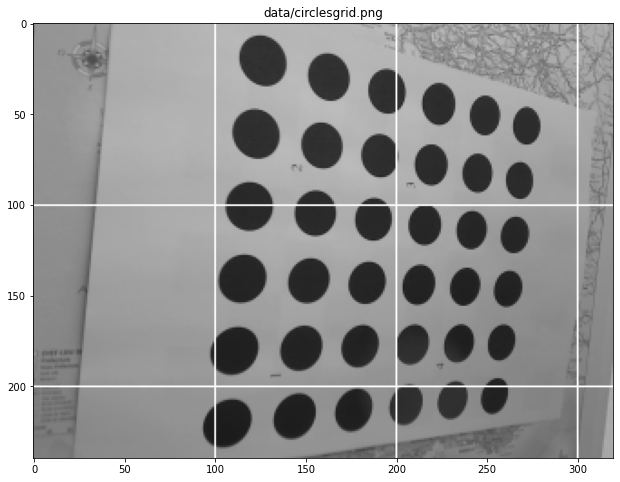

In [2]:
# Read the image
image_orig = cv2.imread('../data/circlesgrid.png', cv2.IMREAD_COLOR)

# Preserve the original image and work its copy
show_img = np.copy(image_orig)



######################################
print_image('data/circlesgrid.png','image_orig',image_orig,300,305,100,123)
plt_view_image(plt,[["data/circlesgrid.png", draw_grid(np.copy(image_orig),100,(255,255,255))]],
               figsize=(16,8), axis='on', cmap='gray')

### Define two functions to implement the process of points selection:

In [3]:
# Create an array to hold the selected points
selected_pts = []

# Create a mouse callback
def mouse_callback(event, x, y, flags, img):
    global selected_pts #, show_img

    if event == cv2.EVENT_LBUTTONUP:
        # append the array with the current point
        selected_pts.append([x, y])
        # and draw a small green circle where clicked
        cv2.circle(img, (x, y), 10, (0, 255, 0), 3)

# Define the select_points funtion
def select_points(image, points_num):
    global selected_pts
    selected_pts = []
    
    cv2.namedWindow('Select {} points on image'.format(points_num))
    cv2.setMouseCallback('Select {} points on image'.format(points_num), mouse_callback,image)

    while True:
        cv2.imshow('Select {} points on image'.format(points_num), image)

        k = cv2.waitKey(1)
        if k == 27 or len(selected_pts) == points_num:
            break

    cv2.destroyAllWindows()

    return np.array(selected_pts, dtype=np.float32)

------  data/circlesgrid.png-----    Shape(240, 320, 3) image_orig: uint8
[[173 173 173] [172 172 172] [172 172 172] [173 173 173] [173 173 173] [168 168 168] [90 90 90] ]
[[172 172 172] [172 172 172] [172 172 172] [172 172 172] [172 172 172] [167 167 167] [86 86 86] ]
[[173 173 173] [172 172 172] [173 173 173] [173 173 173] [173 173 173] [169 169 169] [90 90 90] ]
[[174 174 174] [174 174 174] [173 173 173] [174 174 174] [174 174 174] [172 172 172] [104 104 104] ]
[[175 175 175] [175 175 175] [174 174 174] [174 174 174] [173 173 173] [173 173 173] [131 131 131] ]
------  show_img-----------------    Shape(240, 320, 3) show_img: uint8
[[255 255 255] [255 255 255] [255 255 255] [255 255 255] [255 255 255] [255 255 255] [255 255 255] ]
[[255 255 255] [172 172 172] [172 172 172] [172 172 172] [172 172 172] [167 167 167] [86 86 86] ]
[[255 255 255] [172 172 172] [173 173 173] [173 173 173] [173 173 173] [169 169 169] [90 90 90] ]
[[255 255 255] [174 174 174] [173 173 173] [174 174 174] [174

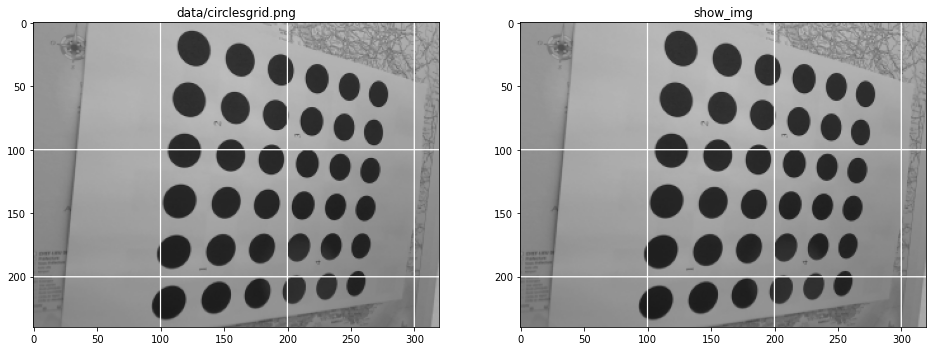

In [4]:
show_img = draw_grid(np.copy(image_orig),100,(255,255,255))



######################################################
print_image('data/circlesgrid.png','image_orig',image_orig,100,105,100,107)
print_image('show_img','show_img',show_img,100,105,100,107)
plt_view_image(plt,[["data/circlesgrid.png", draw_grid(np.copy(image_orig),100,(255,255,255))],
                    ["show_img", show_img]],
               figsize=(16,8), axis='on', cmap='gray')

### Select three points in the image, compute the affine transformation with `cv2.getAffineTransform`, and apply it with `cv2.warpAffine`. Then, show the resulting images:

In [5]:
# getAffineTransform function takes two arguments
# the source points & the destination points for those selected pts

# get the selected points
src_pts = select_points(show_img, 3)


####################
print(src_pts)

[[ 91. 236.]
 [116.   3.]
 [286.  53.]]


In [6]:
# create destination points for our selected ones

# Bottom Left, Top Left, Top right
dst_pts = np.array([[0, 240], [0, 0], [240, 0]], dtype=np.float32)


####################
print(dst_pts)

[[  0. 240.]
 [  0.   0.]
 [240.   0.]]


### Affine Transformation 

Apply affine transformation
30. Трансформация изображения — аффинные преобразования, гомография

Преобразование плоскости(изображения) называется аффинным, если оно взаимно однозначно и образом любой прямой является прямая. Взаимно однозначное преобразование, переводит каждую точку плоскости(изображения) $I$ в другую точку плоскости(изображения) $I'$, таким образом, что каждой точке $I$ соответствует какая-то точка $I'$.

Примеры аффинных преобразований:

* обычное движение — фактически движение является параллельным переносом
* повороты
* растяжения или сжатия относительно прямой

In [7]:
# map_matrix — матрица трансформации.
# Сгенерировать эту матрицу можно с помощью двух методов — 
# cv2.getAffineTransform(src, dst) -> retval - рассчёт матрицы аффинной трансформации из трёх пар точек
#                                        src — 3 координаты исходного изображения
#                                        dst — 3 соотносящихся координаты целевого изображения
#                                 map_matrix — получаемая матрица трансформации 2х3
#
# рассчитывает аффинную матрицу 2D-вращения:
# cv.GetRotationMatrix2D(center, angle, scale, mapMatrix) -> None 

affine_m = cv2.getAffineTransform(src_pts, dst_pts)


######################################################
print("cv2.getAffineTransform =\n",affine_m)

cv2.getAffineTransform =
 [[ 1.36857562e+00  1.46842878e-01 -1.59195301e+02]
 [-2.93685756e-01  9.98531571e-01  3.10719530e+01]]


------  data/circlesgrid.png-----    Shape(240, 320, 3) image_orig: uint8
[[28 28 28] [28 28 28] [28 28 28] [27 27 27] [28 28 28] [27 27 27] [28 28 28] ]
[[28 28 28] [27 27 27] [28 28 28] [28 28 28] [27 27 27] [27 27 27] [28 28 28] ]
[[29 29 29] [27 27 27] [27 27 27] [27 27 27] [27 27 27] [27 27 27] [27 27 27] ]
[[28 28 28] [28 28 28] [27 27 27] [27 27 27] [28 28 28] [27 27 27] [28 28 28] ]
[[27 27 27] [27 27 27] [27 27 27] [27 27 27] [27 27 27] [27 27 27] [27 27 27] ]
------  show_img-----------------    Shape(240, 320, 3) show_img: uint8
[[255 255 255] [28 28 28] [28 28 28] [27 27 27] [28 28 28] [27 27 27] [28 28 28] ]
[[255 255 255] [27 27 27] [28 28 28] [28 28 28] [27 27 27] [27 27 27] [28 28 28] ]
[[255 255 255] [27 27 27] [27 27 27] [27 27 27] [27 27 27] [27 27 27] [27 27 27] ]
[[  0 255   0] [28 28 28] [27 27 27] [27 27 27] [28 28 28] [27 27 27] [28 28 28] ]
[[  0 255   0] [  0 255   0] [27 27 27] [27 27 27] [27 27 27] [27 27 27] [27 27 27] ]
------  Affine 3 points----------   

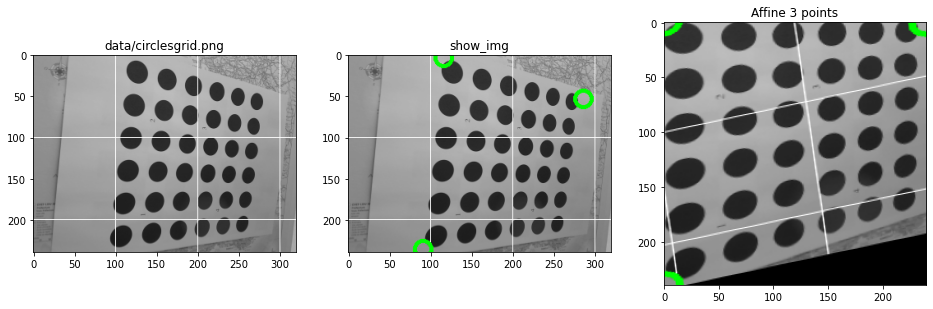

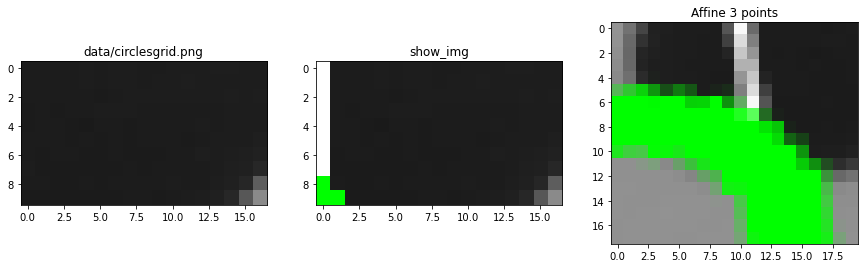

In [8]:
#cv.WarpAffine(src,dst,mapMatrix, flags=CV_INTER_LINEAR+CV_WARP_FILL_OUTLIERS, fillval=(0,0,0,0)) -> None
# src – input image.
# dst – output image that has the size dsize and the same type as src .
# mapMatrix — матрица трансформации 2х3.
# dsize – size of the output image.
# flags — комбинация флагов метода интерполяции и флагов:
#         CV_WARP_FILL_OUTLIERS — заполнить все пиксели целевого изображения 
#                                 (если пиксели отсутствуют на исходном изображени используются fillval)
#         CV_WARP_INVERSE_MAP — используется обратная трансформация из dst -> src
# borderMode – pixel extrapolation method (see borderInterpolate()); when borderMode=BORDER_TRANSPARENT , 
#              it means that the pixels in the destination image corresponding to the “outliers” in the 
#              source image are not modified by the function.
#borderValue – value used in case of a constant border; by default, it is 0.

Affine3_img = cv2.warpAffine(show_img, affine_m, (240, 240))



######################################################
print_image('data/circlesgrid.png','image_orig',image_orig,225,230,100,107)
print_image('show_img','show_img',show_img,225,230,100,107)
print_image('Affine 3 points','Affine3_img',Affine3_img,222,235,5,12)
plt_view_image(plt,[["data/circlesgrid.png", draw_grid(np.copy(image_orig),100,(255,255,255))],
                    ["show_img", show_img],
                    ["Affine 3 points", Affine3_img]],
               figsize=(16,8), axis='on', cmap='gray')
plt_view_image(plt,[["data/circlesgrid.png", image_orig[220:230,100:117]],
                    ["show_img", show_img[220:230,100:117]],
                    ["Affine 3 points", Affine3_img[222:240,0:20]]],
               figsize=(15,6), axis='on', cmap='gray')

cv2.imshow('result', np.hstack((show_img, Affine3_img)))
cv2.waitKey()
cv2.destroyAllWindows()

### Find an inverse affine transformation, apply it, and display the results:

------  data/circlesgrid.png-----    Shape(240, 320, 3) image_orig: uint8
[[28 28 28] [28 28 28] [28 28 28] [27 27 27] [28 28 28] [27 27 27] [28 28 28] ]
[[28 28 28] [27 27 27] [28 28 28] [28 28 28] [27 27 27] [27 27 27] [28 28 28] ]
[[29 29 29] [27 27 27] [27 27 27] [27 27 27] [27 27 27] [27 27 27] [27 27 27] ]
[[28 28 28] [28 28 28] [27 27 27] [27 27 27] [28 28 28] [27 27 27] [28 28 28] ]
[[27 27 27] [27 27 27] [27 27 27] [27 27 27] [27 27 27] [27 27 27] [27 27 27] ]
------  show_img-----------------    Shape(240, 320, 3) show_img: uint8
[[255 255 255] [28 28 28] [28 28 28] [27 27 27] [28 28 28] [27 27 27] [28 28 28] ]
[[255 255 255] [27 27 27] [28 28 28] [28 28 28] [27 27 27] [27 27 27] [28 28 28] ]
[[255 255 255] [27 27 27] [27 27 27] [27 27 27] [27 27 27] [27 27 27] [27 27 27] ]
[[  0 255   0] [28 28 28] [27 27 27] [27 27 27] [28 28 28] [27 27 27] [28 28 28] ]
[[  0 255   0] [  0 255   0] [27 27 27] [27 27 27] [27 27 27] [27 27 27] [27 27 27] ]
------  Affine 3 points----------   

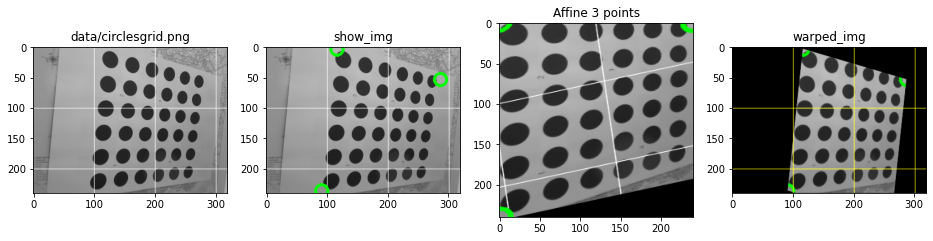

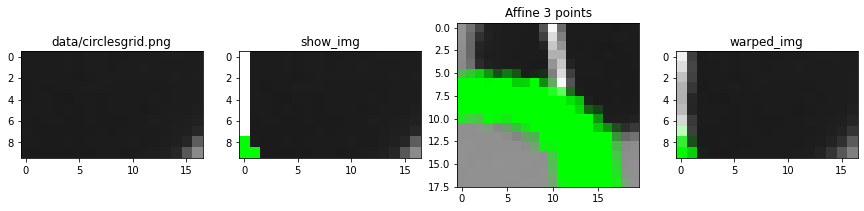

In [9]:
inv_affine = cv2.invertAffineTransform(affine_m)
warped_img = cv2.warpAffine(Affine3_img, inv_affine, (320, 240))



######################################################
print_image('data/circlesgrid.png','image_orig',image_orig,225,230,100,107)
print_image('show_img','show_img',show_img,225,230,100,107)
print_image('Affine 3 points','Affine3_img',Affine3_img,222,235,5,12)
print_image('cv2.invertAffineTransform','warped_img',warped_img,225,230,100,107)

plt_view_image(plt,[["data/circlesgrid.png", draw_grid(np.copy(image_orig),100,(255,255,255))],
                    ["show_img", show_img],
                    ["Affine 3 points", Affine3_img],
                    ["warped_img",  draw_grid(np.copy(warped_img),100,(255,255,0))]],
               figsize=(16,8), axis='on', cmap='gray')
plt_view_image(plt,[["data/circlesgrid.png", image_orig[220:230,100:117]],
                    ["show_img", show_img[220:230,100:117]],
                    ["Affine 3 points", Affine3_img[222:240,0:20]],
                    ["warped_img", warped_img[220:230,100:117]] ],
               figsize=(15,6), axis='on', cmap='gray')

cv2.imshow('Affine 3 points, cv2.warpAffine', 
           np.hstack((show_img, Affine3_img, draw_grid(np.copy(warped_img),100,(0,255,255)))))
k = cv2.waitKey()
cv2.destroyAllWindows()

### Create a rotation-scale affine warp with `cv2.getRotationMatrix2D` and apply it to the image:

In [10]:
rotation_mat = cv2.getRotationMatrix2D(tuple(src_pts[0]), 6, 1)


#########################
print(rotation_mat)

[[  0.9945219    0.10452846 -24.17020981]
 [ -0.10452846   0.9945219   10.80492285]]


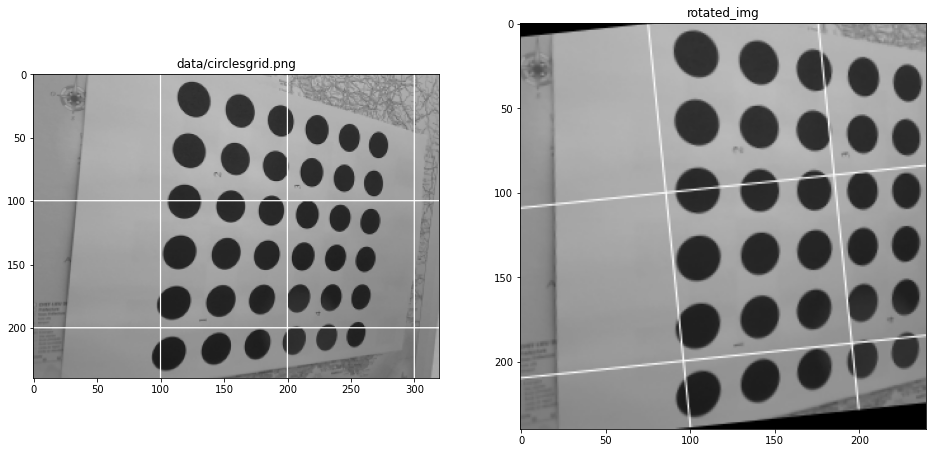

In [11]:
rotated_img = cv2.warpAffine(draw_grid(np.copy(image_orig),100,(255,255,255)), 
                             rotation_mat, (240,240))



######################################################
plt_view_image(plt,[["data/circlesgrid.png", draw_grid(np.copy(image_orig),100,(255,255,255))],
                    ["rotated_img", rotated_img]],
               figsize=(16,8), axis='on', cmap='gray')


cv2.imshow('cv2.getRotationMatrix2D', np.hstack((show_img, rotated_img)))
k = cv2.waitKey()
cv2.destroyAllWindows()

###  Select four points in the image, create a matrix for perspective warp with `cv2.getPerspectiveTransform`, and then apply it to the image and display the results:

src_pts =
 [[ 92. 236.]
 [116.   4.]
 [286.  52.]
 [266. 215.]]
dst_pts =
 [[  0. 240.]
 [  0.   0.]
 [240.   0.]
 [240. 240.]]


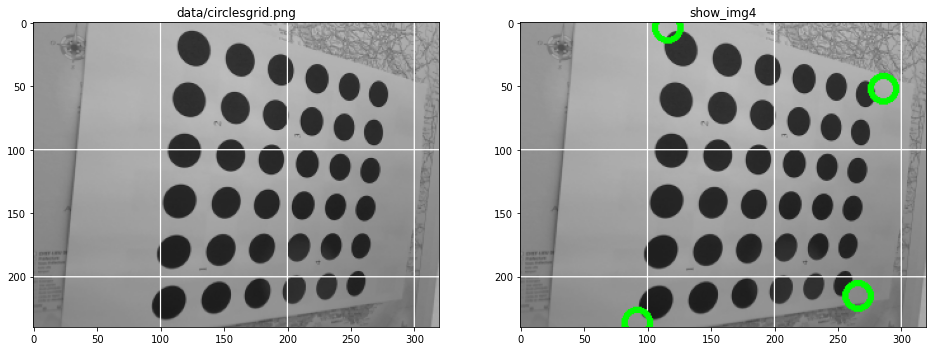

In [12]:
show_img4 = draw_grid(np.copy(image_orig),100,(255,255,255))

src_pts = select_points(show_img4, 4)
dst_pts = np.array([[0, 240], [0, 0], [240, 0], [240, 240]], dtype=np.float32)



####################################
print("src_pts =\n",src_pts)
print("dst_pts =\n",dst_pts)

plt_view_image(plt,[["data/circlesgrid.png", draw_grid(np.copy(image_orig),100,(255,255,255))],
                    ["show_img4", show_img4]],
               figsize=(16,8), axis='on', cmap='gray')

### Perspective Transformation

In [13]:
#cv2.getPerspectiveTransform(src, dst) -> mapMatrix 3*3 matrix of a perspective transform
# src – Coordinates of 4 quadrangle vertices in the source image.
# dst – Coordinates of the corresponding 4 quadrangle vertices in the destination image.

perspective_matrix = cv2.getPerspectiveTransform(src_pts, dst_pts)


#######################################
print("perspective_matrix =\n",perspective_matrix)

perspective_matrix =
 [[ 8.03952944e-01  8.31675460e-02 -9.35912117e+01]
 [-2.31279460e-01  8.19114752e-01  2.35519583e+01]
 [-1.40415199e-03 -2.36776033e-04  1.00000000e+00]]


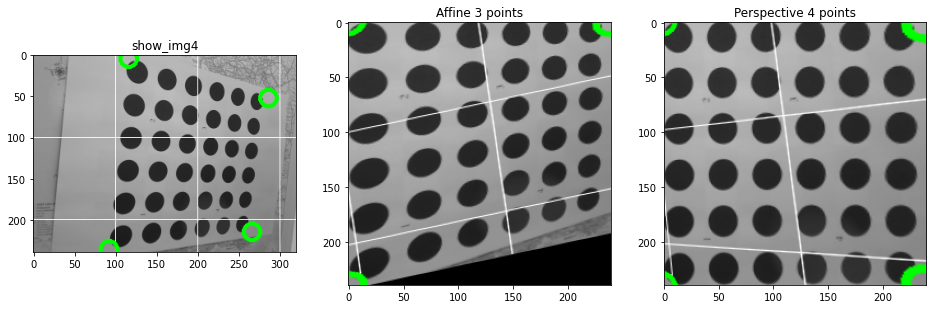

In [14]:
#cv2.warpPerspective(src, mapMatrix, dsize[, dst[, flags[, borderMode[, borderValue]]]]) -> dst
# src — исходное изображение
# dst — целевое изображение
# mapMatrix — матрица трансформации 3х3
# dsize – size of the output image.
# flags – combination of interpolation methods (INTER_LINEAR or INTER_NEAREST) and the optional
#         flag WARP_INVERSE_MAP, that sets M as the inverse transformation (dst -> src).
# borderMode – pixel extrapolation method (BORDER_CONSTANT or BORDER_REPLICATE).
# borderValue – value used in case of a constant border; by default, it equals 0.

warpPerspective_img = cv2.warpPerspective(show_img4, perspective_matrix, (240, 240))



########################################################
plt_view_image(plt,[["show_img4", show_img4],
                    ["Affine 3 points", Affine3_img],
                    ["Perspective 4 points", warpPerspective_img]
                   ],
               figsize=(16,8), axis='on', cmap='gray')

cv2.imshow('show_img4, Affine 3 points, Perspective 4 points', 
           np.hstack((show_img4, Affine3_img, warpPerspective_img)))
k = cv2.waitKey()
cv2.destroyAllWindows()